In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import qiime2 as q2
import biom
import h5py
import pandas as pd 
import numpy as np
import scipy.stats as ss
import skbio

In [2]:
# load mass spec table 
ms_0613 = q2.Artifact.load('qiime2_table_20210613.qza').view(biom.Table)
md = pd.read_csv('pths_study_specific_metadata.tsv', sep='\t',dtype='str').set_index('#SampleID')

In [3]:
ms_0613.ids()[0:10]

array(['PH101161_GE8_01_38776.mzXML', 'PH101162_GB8_01_38740.mzXML',
       'PH101163_GE4_01_38772.mzXML', 'PH101164_GH8_01_38826.mzXML',
       'PH101165_GB5_01_38737.mzXML', 'PH101166_GG7_01_38799.mzXML',
       'PH101167_GD7_01_38763.mzXML', 'PH101168_GB11_01_38743.mzXML',
       'PH101172_GC11_01_38755.mzXML', 'PH101173_GD9_01_38765.mzXML'],
      dtype=object)

In [4]:
# update ids so that we match the Qiita IDs 
ms_0613 = ms_0613.update_ids({i: "10317.000%s" % i[2:8] for i in ms_0613.ids()}, inplace=False)
ms_0613.ids()[0:10]

array(['10317.000101161', '10317.000101162', '10317.000101163',
       '10317.000101164', '10317.000101165', '10317.000101166',
       '10317.000101167', '10317.000101168', '10317.000101172',
       '10317.000101173'], dtype=object)

In [5]:
# check to make sure all of the ids in the ms table are present in the metadata 
ms_0613 = ms_0613.filter(set(md.index) & set(ms_0613.ids()), inplace=False).remove_empty()
ms_0613

1780 x 84 <class 'biom.table.Table'> with 24014 nonzero entries (16% dense)

In [6]:
# make a biom table with the proper sample ids  
f = h5py.File('pths_ms_table_20210613.biom', 'w')
ms_0613.to_hdf5(f, 'asd')
f.close()

# import this biom table to q2 artifact 
!qiime tools import \
  --input-path pths_ms_table_20210613.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_table_20210613.qza

Imported pths_ms_table_20210613.biom as BIOMV210Format to pths_ms_table_20210613.qza


In [8]:
# filter the feature table so that only those features present in at least 3 samples are kept  
!qiime feature-table filter-features \
    --i-table pths_ms_table_20210613.qza \
    --p-min-samples 3 \
    --o-filtered-table pths_ms_table_06.13.21_min3samples.qza

# check that the feature table looks ok
q2.Artifact.load('pths_ms_table_06.13.21_min3samples.qza').view(pd.DataFrame).head()

Saved FeatureTable[Frequency] to: pths_ms_table_06.13.21_min3samples.qza


,2,3,4,5,6,7,8,9,10,11,...,11115,11149,11150,11252,11257,11301,11453,11498,11590,11596
10317.000101161,1295257.569,1.013464e+06,9.561086e+05,784191.3035,8.230496e+05,887304.390,700903.43,629621.4500,767895.7400,559433.7400,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000101162,0.000,1.075620e+06,0.000000e+00,0.0000,7.849496e+05,0.000,0.00,0.0000,545814.7475,620379.2720,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000101163,917823.951,5.315436e+05,1.014932e+06,317998.7270,5.938789e+06,0.000,0.00,507339.7880,0.0000,304443.9415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000101164,950016.812,7.810008e+05,6.422567e+05,831425.8320,9.459950e+05,0.000,0.00,485643.1305,989786.2780,453232.5780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10317.000101165,998698.964,1.931557e+05,9.700231e+05,0.0000,1.220157e+05,2396618.876,0.00,738852.6055,170710.4080,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# run songbird on metabolomics feature table
# first we'll do the null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_table_06.13.21_min3samples.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials ms061321_differentials_null.qza \
    --o-regression-stats ms061321_regression_stats_null.qza \
    --o-regression-biplot ms061321_regression_biplot_null.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_table_06.13.21_min3samples.qza \
    --m-metadata-file pths_study_specific_metadata.tsv \
    --p-formula "pths_status" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials ms061321_differentials_pths_status.qza \
    --o-regression-stats ms061321_regression_stats_pths_status.qza \
    --o-regression-biplot ms061321_regression_biplot_pths_status.qza

Saved FeatureData[Differential] to: ms061321_differentials_null.qza
Saved SampleData[SongbirdStats] to: ms061321_regression_stats_null.qza
Saved PCoAResults % Properties('biplot') to: ms061321_regression_biplot_null.qza
Saved FeatureData[Differential] to: ms061321_differentials_pths_status.qza
Saved SampleData[SongbirdStats] to: ms061321_regression_stats_pths_status.qza
Saved PCoAResults % Properties('biplot') to: ms061321_regression_biplot_pths_status.qza


In [11]:
# check the performance of the model 
!qiime songbird summarize-paired \
    --i-regression-stats ms061321_regression_stats_pths_status.qza \
    --i-baseline-stats ms061321_regression_stats_null.qza \
    --o-visualization ms061321-pths_status.qzv

!qiime tools view ms061321-pths_status.qzv

Saved Visualization to: ms061321-pths_status.qzv
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.
Press the 'q' key, Control-C, or Control-D to quit. This view may no longer be accessible or work correctly after quitting.

In [15]:
# the pseudo-Q^2 of the above model is negative 
# furthermore, we want to account for age in the Songbird model since age is potential confounder 
md_w_age = md.loc[md['age_years'] != "Missing: Not provided"]
md_w_age['age_years'] = md_w_age['age_years'].astype("float64")

# save metadata that is filtered to age
md_w_age.to_csv('pths_metadata_age_float.tsv', sep='\t')

# keep only PTHS individuals under 20 and unaffected individuals 
samples_to_keep = md_w_age.loc[(md_w_age['age_years'] < 20) | (md_w_age['pths_status'] == 'is_not_affected')].index

# filter so that the ms feature table so that we only keep samples filtered above 
ms_0613 = ms_0613.filter(set(samples_to_keep) & set(ms_0613.ids()), inplace=False).remove_empty()
ms_0613

/Users/hazedil/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1780 x 72 <class 'biom.table.Table'> with 21273 nonzero entries (16% dense)

In [16]:
# write filtered table to .biom table
f = h5py.File('pths_ms_age_20210613.biom', 'w')
ms_0613.to_hdf5(f, 'asd')
f.close()

# import filtered table into qiime qza 
!qiime tools import \
  --input-path pths_ms_age_20210613.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_age_20210613.qza

# filter feature table so that only features present in at least 3 samples are kept 
!qiime feature-table filter-features \
    --i-table pths_ms_age_20210613.qza \
    --p-min-samples 3 \
    --o-filtered-table pths_ms_age_20210613_min3samples.qza

Imported pths_ms_age_20210613.biom as BIOMV210Format to pths_ms_age_20210613.qza
Saved FeatureTable[Frequency] to: pths_ms_age_20210613_min3samples.qza


In [17]:
# run Songbird on the newest feature table 
# first null songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age_20210613_min3samples.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "1" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials ms061321_filtered_differentials_null.qza \
    --o-regression-stats ms061321_filtered_regression_stats_null.qza \
    --o-regression-biplot ms061321_filtered_regression_biplot_null.qza

# run pths_status songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age_20210613_min3samples.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "pths_status" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials ms061321_filtered_differentials_pths_status.qza \
    --o-regression-stats ms061321_filtered_regression_stats_pths_status.qza \
    --o-regression-biplot ms061321_filtered_regression_biplot_pths_status.qza

# run pths_status + age_years songbird model 
!qiime songbird multinomial \
    --i-table pths_ms_age_20210613_min3samples.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --p-formula "pths_status + age_years" \
    --p-epochs 2500 \
    --p-summary-interval 0.1 \
    --o-differentials ms061321_filtered_differentials_pths_status_age.qza \
    --o-regression-stats ms061321_filtered_regression_stats_pths_status_age.qza \
    --o-regression-biplot ms061321_filtered_regression_biplot_pths_status_age.qza

Saved FeatureData[Differential] to: ms061321_filtered_differentials_null.qza
Saved SampleData[SongbirdStats] to: ms061321_filtered_regression_stats_null.qza
Saved PCoAResults % Properties('biplot') to: ms061321_filtered_regression_biplot_null.qza
Saved FeatureData[Differential] to: ms061321_filtered_differentials_pths_status.qza
Saved SampleData[SongbirdStats] to: ms061321_filtered_regression_stats_pths_status.qza
Saved PCoAResults % Properties('biplot') to: ms061321_filtered_regression_biplot_pths_status.qza
Saved FeatureData[Differential] to: ms061321_filtered_differentials_pths_status_age.qza
Saved SampleData[SongbirdStats] to: ms061321_filtered_regression_stats_pths_status_age.qza
Saved PCoAResults % Properties('biplot') to: ms061321_filtered_regression_biplot_pths_status_age.qza


In [ ]:
# filter table so that we only have the features used by songbird 
tabms = biom.load_table('pths_ms_age_20210613.biom')
s_diffs = q2.Artifact.load('ms061321_filtered_differentials_pths_status_age.qza').view(pd.DataFrame)
sb = tabms.filter(set(s_diffs.index), inplace=False, axis='observation').remove_empty()

f = h5py.File('pths_ms_20210613_used_by_songbird.biom', 'w')
sb.to_hdf5(f, 'asd')
f.close()

!qiime tools import \
  --input-path pths_ms_20210613_used_by_songbird.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_20210613_used_by_songbird.qza

# now that songbird table is filtered, we can run mmvec 
t_sg = q2.Artifact.load('../PTHS_Metabolomics/Pitt_Hopkins_shotgun_shogun_gotu_min3samples.qza').view(biom.Table)
t_ms = q2.Artifact.load('pths_ms_20210613_used_by_songbird.qza').view(biom.Table)

# notice how each table above has different numbers of samples 
# filter tables so that they all have same samples
t_sg.filter(set(t_ms.ids()) & set(t_sg.ids()), inplace=True).remove_empty()
t_ms.filter(set(t_ms.ids()) & set(t_sg.ids()), inplace=True).remove_empty()

# write filtered shotgun data 
f = h5py.File('pths_shotgun_shogun_filtered_210613.biom', 'w')
t_sg.to_hdf5(f, 'asd')
f.close()

# write filtered ms data 
f = h5py.File('pths_ms_filtered_210613.biom', 'w')
t_ms.to_hdf5(f, 'asd')
f.close()

# import filtered data into qiime
!qiime tools import \
  --input-path pths_shotgun_shogun_filtered_210613.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_shotgun_shogun_filtered_210613.qza
!qiime tools import \
  --input-path pths_ms_filtered_210613.biom \
  --type 'FeatureTable[Frequency]' \
  --input-format BIOMV210Format \
  --output-path pths_ms_filtered_210613.qza

In [ ]:
!qiime mmvec paired-omics \
    --i-microbes pths_shotgun_shogun_filtered_210613.qza \
    --i-metabolites pths_ms_filtered_210613.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
    --o-conditionals mmvec_210614/PTHS_shogun_ms_conditionals_061421.qza \
    --o-conditional-biplot mmvec_210614/PTHS_shogun_ms_conditional_biplot_061421.qza \
    --o-model-stats mmvec_210614/PTHS_shogun_ms_model_stats_061421.qza

qiime mmvec paired-omics \
    --i-microbes pths_ms_filtered_210613.qza \
    --i-metabolites pths_shotgun_shogun_filtered_210613.qza \
    --m-metadata-file pths_metadata_age_float.tsv \
   --o-conditionals mmvec_210614/PTHS_shogun_ms_inverted_conditionals_061421.qza \
    --o-conditional-biplot mmvec_210614/PTHS_shogun_ms_inverted_conditional_biplot_061421.qza \
    --o-model-stats mmvec_210614/PTHS_shogun_ms_inverted_model_stats_061421.qza

In [4]:
# load the mmvec artifacts 
mmvec_ranks = q2.Artifact.load('mmvec_210614/PTHS_shogun_ms_conditionals_061421.qza').view(pd.DataFrame)
mmvec_biplot = q2.Artifact.load('mmvec_210614/PTHS_shogun_ms_conditional_biplot_061421.qza').view(skbio.OrdinationResults)
mmvec_inv_ranks = q2.Artifact.load('mmvec_210614/PTHS_shogun_ms_inverted_conditionals_061421.qza').view(pd.DataFrame)
mmvec_inv_biplot = q2.Artifact.load('mmvec_210614/PTHS_shogun_ms_inverted_conditional_biplot_061421.qza').view(skbio.OrdinationResults)

# load the Songbird differentials 
ms_diff = q2.Artifact.load('ms061321_filtered_differentials_pths_status_age.qza').view(pd.DataFrame)
ms_diff_no_age = q2.Artifact.load('ms061321_filtered_differentials_pths_statusqza').view(pd.DataFrame)

,Intercept,pths_status[T.is_not_affected]
featureid,,
2,2.033357,0.579872
3,3.248022,0.218557
4,2.828145,0.681015
5,2.589966,0.213854
6,3.151729,1.173281
...,...,...
9028,-2.409558,1.197102
9972,1.577043,-0.703152
10042,-0.715957,-0.200908


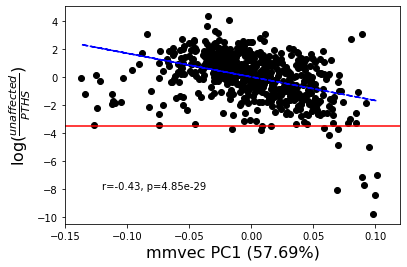

In [6]:
# generate Songbird versus mmvec figure 

x = mmvec_biplot.samples[0]
y = ms_diff['pths_status[T.is_not_affected]']

plt.scatter(x, y, color='k')
plt.xlim(-.15, .12)
ax = plt.gca()
ax.set_xlabel("mmvec PC1 (%0.2f%%)" % (mmvec_biplot.proportion_explained[0] * 100), fontsize=16)
ax.set_ylabel(r"log($\frac{unaffected}{PTHS})$", fontsize=16)

# line of best fit 
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"b--")
ax.text(-0.12, -8, "r=%0.2f, p=%0.2e" % ss.spearmanr(x,y))

# cutoff for significance 
plt.plot([-0.15, 0.15], [-3.5, -3.5], linestyle = 'solid', c='r')

plt.savefig('mmvec_identity.pdf')

In [5]:
top_mmvec = mmvec_ranks[['G000371705', 'G000431175']].loc[mmvec_ranks['G000371705'] > 3].index
bolt_ranks = mmvec_ranks[['G000371705', 'G000431175']].sort_values(by='G000431175', axis=0)
ms_diff.loc[ms_diff['pths_status[T.is_not_affected]'] < -3.5].sort_values(by='pths_status[T.is_not_affected]').to_csv('songbird_diffs_for_figure.csv')

In [188]:
# generate cytoscape labels for cytoscape molecular network 
ms_ft = q2.Artifact.load('pths_ms_table_06.13.21_min3samples.qza').view(pd.DataFrame)
fracs = []
assignment = []
affected = []
unaffected = []

for feat in ms_ft.columns:
    nonzero_indices = ms_ft.index[ms_ft[feat].nonzero()]
    num_affected = sum(md_w_age.loc[nonzero_indices]['pths_status'] == 'is_affected')
    frac_affected = num_affected / len(nonzero_indices)
    fracs.append(frac_affected)
    affected.append(num_affected) 
    unaffected.append(len(nonzero_indices) - num_affected)
    
    if frac_affected > 0.7: 
        assignment.append('PTHS Enriched')
    elif frac_affected < 0.3: 
        assignment.append('Unaffected Enriched')
    else: 
        assignment.append('Mixed')

cytoscape_labels = pd.DataFrame({'FeatureID': ms_ft.columns, 'PTHS Fraction': fracs, 'Label': assignment, 
                                 'Affected_PTHS': affected, 'Unaffected_PTHS': unaffected})
cytoscape_labels.to_csv('cytoscape_labels.tsv', sep='\t', index=False )

In [90]:
# take the rclr to look at log ratios for different ms features; you can do this with deicode / gemelli 
!qiime gemelli rclr-transformation \
    --i-table pths_ms_table_06.12.21_min3samples.qza \
    --o-rclr-table pths_ms_06.12.21_min3samples_rclr.qza

Saved FeatureTable[Composition] to: pths_ms_06.12.21_min3samples_rclr.qza


In [431]:
# features identified through above dataframes 
bottom_mmvec = ['3058', '2270', '6806', '1643', '3139' ]
top_mmvec = ['22', '63', '862', '867']
songbird_sig = ['1312', '1499', '2384', '2475', '1027', '1140', '1674', '867']

In [356]:
# visualize rclr ratios and make a figure 
rclr = rclr_table[top_mmvec]
rclr['pths_status'] = md_w_age.loc[rclr.index]['pths_status']
rclr['SampleID'] = rclr.index

rclr_fig = rclr.melt(id_vars=['SampleID', 'pths_status'], value_vars=top_mmvec, var_name='FeatureID', value_name='log ratio')
rclr_fig

/Users/hazedil/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/hazedil/opt/anaconda3/envs/qiime2-2020.11/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SampleID,pths_status,FeatureID,log ratio
0,10317.000101161,is_not_affected,22,1.352615
1,10317.000101162,is_affected,22,NaN
2,10317.000101163,is_not_affected,22,2.075546
3,10317.000101165,is_affected,22,3.500346
4,10317.000101166,is_not_affected,22,3.141349
...,...,...,...,...
283,10317.000101411,is_not_affected,867,NaN
284,10317.000101412,is_affected,867,NaN
285,10317.000102791,is_affected,867,NaN
286,10317.000102792,is_not_affected,867,1.868307


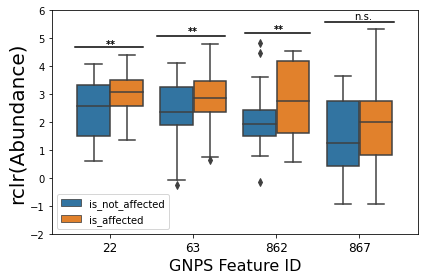

In [371]:
plt.figure()
plt.ylim(-2, 6)
sns.boxplot(data=rclr_fig, x='FeatureID', y='log ratio', order=top_mmvec, hue='pths_status')
plt.legend(loc='lower left')
ax = plt.gca()
ax.set_ylabel("rclr(Abundance)", fontsize=20)
plt.plot([-0.42, 0.39], [4.7, 4.7], linestyle = 'solid', c='k')
ax.text(-0.05, 4.7, '**')
ax.text(-0.05, 4.7, '**')
plt.plot([0.56, 1.38], [5.1,5.1], linestyle = 'solid', c='k')
ax.text(0.93, 5.15, '**')
ax.text(0.93, 5.15, '**')
plt.plot([1.62, 2.4], [5.2,5.2], linestyle = 'solid', c='k')
ax.text(1.97, 5.23, '**')
ax.text(1.97, 5.23, '**')
plt.plot([2.58, 3.41], [5.6,5.6], linestyle = 'solid', c='k')
ax.text(2.94, 5.68, 'n.s.')
ax.set_xlabel("GNPS Feature ID", fontsize=16)
ax.set_xticklabels(top_mmvec, fontsize=12)
plt.tight_layout()
plt.savefig('rclr_only.pdf')

# plt.plot()
# ax.text()

In [358]:
# get statistics for rclr figure 
for f_id in top_mmvec: 
    m_w = ss.mannwhitneyu(rclr_fig[(rclr_fig.pths_status == 'is_affected') & (rclr_fig.FeatureID == f_id)]['log ratio'], 
                          rclr_fig[(rclr_fig.pths_status == 'is_not_affected') & (rclr_fig.FeatureID == f_id)]['log ratio'])
    print(f_id, m_w)

22 MannwhitneyuResult(statistic=436.0, pvalue=0.009061407545653353)
63 MannwhitneyuResult(statistic=498.0, pvalue=0.048080476880169726)
862 MannwhitneyuResult(statistic=298.0, pvalue=4.43297697008056e-05)
867 MannwhitneyuResult(statistic=588.0, pvalue=0.25830386728166776)


In [2]:
# load in the ReDU data for mmvec features 
r_22 = pd.read_csv('/Users/hazedil/Documents/PTHS/210615_ReDU/22_redu.csv')
r_22['FeatureID'] = 22
r_63 = pd.read_csv('/Users/hazedil/Documents/PTHS/210615_ReDU/63_redu.csv')
r_63['FeatureID'] = 63
r_867 = pd.read_csv('/Users/hazedil/Documents/PTHS/210615_ReDU/867_redu.csv')
r_867['FeatureID'] = 867
mmvec_redu = pd.concat([r_22, r_63, r_867])

# keep the attributes that you think are interesting 
disease = mmvec_redu.loc[(mmvec_redu['Attribute']=='DOIDCommonName')]
disease = disease.loc[disease.Term.isin(["Crohn's disease", "obesity", "ulcerative colitis", "inflammatory bowel disease"])]
disease = disease.sort_values(by=['Observations', 'Total Files'])
disease

,Attribute,Term,Observations,Total Files,Percentage,FeatureID
37,DOIDCommonName,ulcerative colitis,0,144,0.000000,63
37,DOIDCommonName,ulcerative colitis,0,144,0.000000,867
22,DOIDCommonName,Crohn's disease,0,207,0.000000,63
21,DOIDCommonName,Crohn's disease,1,207,0.004831,867
22,DOIDCommonName,inflammatory bowel disease,2,84,0.023810,22
13,DOIDCommonName,inflammatory bowel disease,12,84,0.142857,63
15,DOIDCommonName,obesity,16,679,0.023564,63
13,DOIDCommonName,inflammatory bowel disease,47,84,0.559524,867
15,DOIDCommonName,ulcerative colitis,48,144,0.333333,22
14,DOIDCommonName,Crohn's disease,71,207,0.342995,22


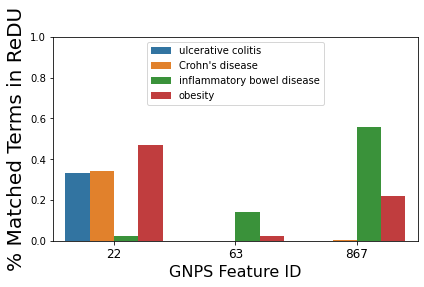

In [3]:
# create figure from ReDU features 
plt.figure()
plt.ylim(0, 1)
sns.barplot(data=disease, x='FeatureID', y='Percentage', hue='Term')
plt.legend(loc='upper center')
ax = plt.gca()
ax.set_ylabel("% Matched Terms in ReDU", fontsize=20)
ax.set_xlabel("GNPS Feature ID", fontsize=16)
ax.set_xticklabels(['22', '63', '867'], fontsize=12)
plt.tight_layout()
plt.savefig('redu_mmvec_feats.pdf')

In [18]:
# load in the ReDU data for Songbird features 
r_1312 = pd.read_csv('/Users/hazedil/Documents/PTHS/210615_ReDU/1312_redu.csv')
r_1312['FeatureID'] = 1312
r_2384 = pd.read_csv('/Users/hazedil/Documents/PTHS/210615_ReDU/2384_redu.csv')
r_2384['FeatureID'] = 2384
r_1674 = pd.read_csv('/Users/hazedil/Documents/PTHS/210615_ReDU/1674_redu.csv')
r_1674['FeatureID'] = 1674
songbird_redu = pd.concat([r_867, r_1674, r_1312, r_2384])

disease = songbird_redu.loc[(songbird_redu['Attribute']=='DOIDCommonName')]
disease = disease.loc[disease.Term.isin(["Crohn's disease", "obesity", "ulcerative colitis", "inflammatory bowel disease"])]
disease = disease.sort_values(by=['Observations', 'Total Files'])
disease

,Attribute,Term,Observations,Total Files,Percentage,FeatureID
37,DOIDCommonName,ulcerative colitis,0,144,0.000000,867
37,DOIDCommonName,ulcerative colitis,0,144,0.000000,1674
37,DOIDCommonName,ulcerative colitis,0,144,0.000000,2384
27,DOIDCommonName,Crohn's disease,0,207,0.000000,1674
27,DOIDCommonName,Crohn's disease,0,207,0.000000,2384
25,DOIDCommonName,ulcerative colitis,1,144,0.006944,1312
21,DOIDCommonName,Crohn's disease,1,207,0.004831,867
26,DOIDCommonName,Crohn's disease,1,207,0.004831,1312
15,DOIDCommonName,inflammatory bowel disease,34,84,0.404762,1674
13,DOIDCommonName,inflammatory bowel disease,47,84,0.559524,867


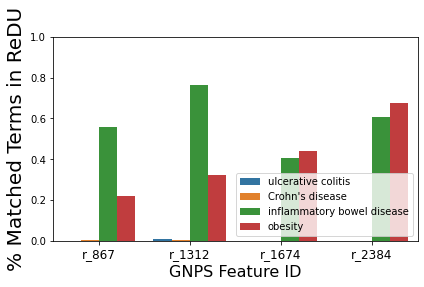

In [22]:
# make figure for Songbird features 
plt.figure()
plt.ylim(0, 1)
sns.barplot(data=disease, x='FeatureID', y='Percentage', hue='Term')
plt.legend(loc='lower right')
ax = plt.gca()
ax.set_ylabel("% Matched Terms in ReDU", fontsize=20)
ax.set_xlabel("GNPS Feature ID", fontsize=16)
ax.set_xticklabels(['r_867', 'r_1312', 'r_1674', 'r_2384'], fontsize=12)
plt.tight_layout()
plt.savefig('redu_songbird_feats.pdf')